<a href="https://colab.research.google.com/github/jason2020/ECE188DeepLearning/blob/main/Adv_example_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

**Before start**
Please create a folder in Files name is content, and upload all 11 images we provide to this folder. You can get the image from [here](https://drive.google.com/file/d/1x1vuHxJse7bbnbrvMiovnD0diq1dr7yq/view?usp=share_link)

**What to submit**

Please use File->print->save as PDF to print your all code and result into a PDF file, and upload it to gradescope.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [ ]:
image_raw = tf.io.read_file('content/panda.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 1s 1s/step


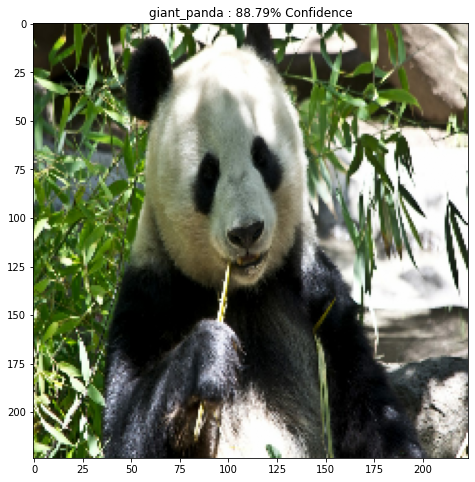

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Task 1: Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):

  with tf.GradientTape() as t:
    t.watch(input_image)
    pred = pretrained_model(input_image)
    loss = loss_object(input_label, pred)
  
  gradient = t.gradient(loss, input_image)

  gradient_sign = tf.sign(gradient)

  # adversarial_image = image + 0.005 * gradient_sign

  return gradient_sign


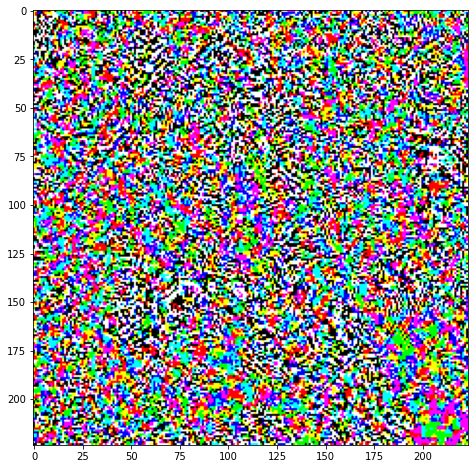

In [ ]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - 0s 70ms/step


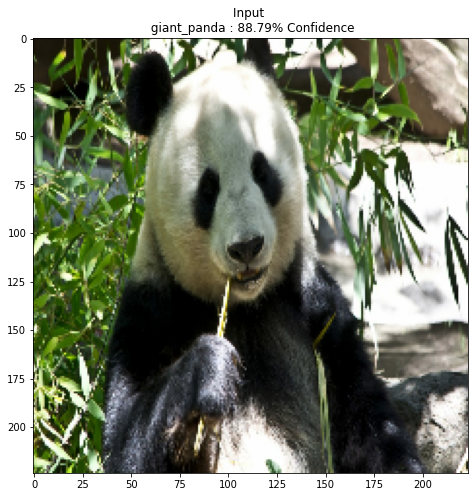

1/1 [==============================] - 0s 84ms/step


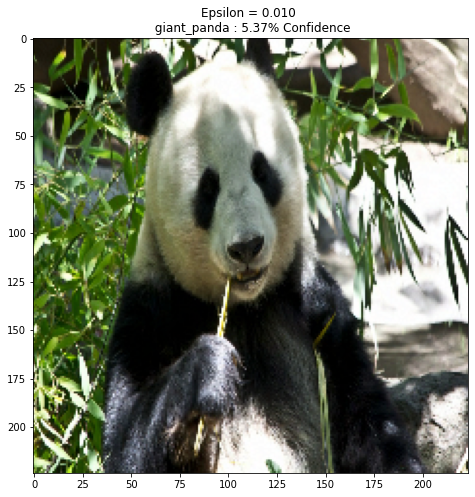

1/1 [==============================] - 0s 61ms/step


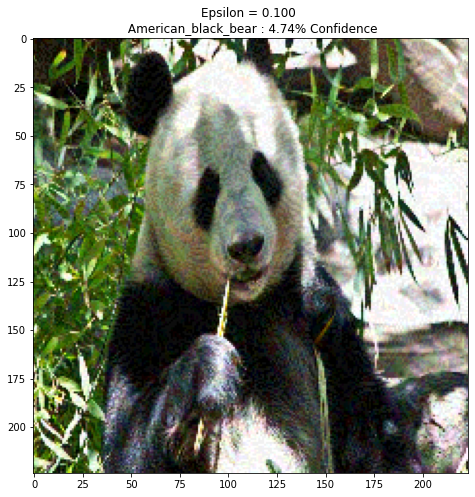

1/1 [==============================] - 0s 56ms/step


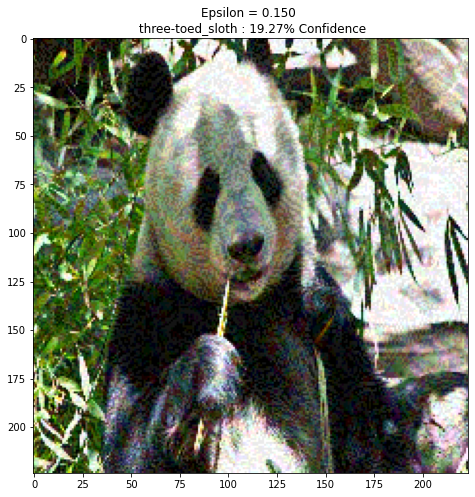

<IPython.core.display.Javascript object>

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. (We already provide it under content folder)
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [ ]:
from IPython.display import Markdown
from tabulate import tabulate

def pertubationAnalysis(model, extended_input_range, preprocess = preprocess, get_imagenet_label = get_imagenet_label):
  # The parameters corresponding for MobileNetV2 by default.
  # In Task3 you need to pass corresponding preprocess and get_imagenet_label for different models.
  
  image_indices = [6,7,276,9,10,11,12,318,14,367,59] # Length of 11? Instructions say pick 10 images?
  smallest_epsilon = []

  for i in range(0, 10):
    # load image
    image_raw = tf.io.read_file('content/image{0}.JPEG'.format(i))
    image = tf.image.decode_image(image_raw)

    # do the prediction
    image = preprocess(image)
    image_probs = model.predict(image)
    _, image_class, class_confidence = get_imagenet_label(image_probs)

    # Get the input label of the image.
    image_index = image_indices[i]
    label = tf.one_hot(image_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    # Get the perturbations
    perturbations = create_adversarial_pattern(image, label)

    # TODO
    # please implement your analysis in here, and print the result
    
    # Will test these epsilon values
    for epsilon in  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]:

      # Multiply by 255 for ResNet152, ResNet101, and VGG16 (according to Campuswire post)
      if(extended_input_range):
        adv_x = image + epsilon * 255 * perturbations
      else:
        adv_x = image + epsilon * perturbations

      # Get rid of clipping according to Campuswire post
      # adv_x = tf.clip_by_value(adv_x, -1, 1) 

      adv_image_probs = model.predict(adv_x)
      adv__, adv_image_class, adv_class_confidence = get_imagenet_label(adv_image_probs)
      if(image_class != adv_image_class):
        smallest_epsilon.append(epsilon)
        break
      if epsilon == 1.0:
        smallest_epsilon.append(-1)

  table_data = []
  for i in range(len(smallest_epsilon)):
    table_data.append([image_indices[i], smallest_epsilon[i]])


  return table_data
    

In [ ]:
MobileNet_epsilon = pertubationAnalysis(pretrained_model, False)

1/1 [==============================] - 0s 39ms/step


In [ ]:
headers1 = ["Image Index", "Smallest Epsilon Value"]

print(tabulate(MobileNet_epsilon, headers=headers1))

  Image Index    Smallest Epsilon Value
-------------  ------------------------
            6                     0.1
            7                     0.001
          276                     0.01
            9                     0.01
           10                     0.005
           11                     0.005
           12                     0.5
          318                     0.01
           14                     0.001
          367                     0.5


# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (We already provided to you).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 

Write the Code for the above below. You can also add the table and answer to the question below. 

In [ ]:
models = {
  "ResNet152": tf.keras.applications.ResNet152(include_top=True, weights='imagenet'),
  "ResNet101": tf.keras.applications.ResNet101(include_top=True, weights='imagenet'),
  "ResNet152V2": tf.keras.applications.ResNet152V2(include_top=True, weights='imagenet'),
  "ResNet50V2": tf.keras.applications.ResNet50V2(include_top=True, weights='imagenet'),
  "VGG16": tf.keras.applications.VGG16(include_top=True, weights='imagenet')
}

# The following are the correct preprocess and get_imagenet_label functions for corresponding models
# ResNet152 & ResNet101
def resnet_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.resnet.preprocess_input(image)
  image = image[None, ...]
  return image

def resnet_get_imagenet_label(probs):
    decode_predictions = tf.keras.applications.resnet.decode_predictions
    return decode_predictions(probs, top=1)[0][0]

# ResNet152V2 & ResNet50V2
def resnet_v2_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.resnet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

def resnet_v2_get_imagenet_label(probs):
    decode_predictions = tf.keras.applications.resnet_v2.decode_predictions
    return decode_predictions(probs, top=1)[0][0]

# VGG16
def vgg16_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.vgg16.preprocess_input(image)
  image = image[None, ...]
  return image

def vgg16_get_imagenet_label(probs):
    decode_predictions = tf.keras.applications.vgg16.decode_predictions
    return decode_predictions(probs, top=1)[0][0]

In [ ]:
# TODO
# Please perform Task2 on all the considered models. 

ResNet152_epsilon = pertubationAnalysis(models["ResNet152"], True, resnet_preprocess, resnet_get_imagenet_label)
ResNet101_epsilon = pertubationAnalysis(models["ResNet101"], True, resnet_preprocess, resnet_get_imagenet_label)
ResNet152V2_epsilon = pertubationAnalysis(models["ResNet152V2"], False, resnet_v2_preprocess, resnet_v2_get_imagenet_label)
ResNet50V2_epsilon = pertubationAnalysis(models["ResNet50V2"], False, resnet_v2_preprocess, resnet_v2_get_imagenet_label)
VGG16_epsilon = pertubationAnalysis(models["VGG16"], True, vgg16_preprocess, vgg16_get_imagenet_label)

1/1 [==============================] - 1s 572ms/step


In [ ]:
ResNet152_epsilon = [inner_list[1] for inner_list in ResNet152_epsilon]
ResNet101_epsilon = [inner_list[1] for inner_list in ResNet101_epsilon]
ResNet152V2_epsilon = [inner_list[1] for inner_list in ResNet152V2_epsilon]
ResNet50V2_epsilon = [inner_list[1] for inner_list in ResNet50V2_epsilon]
VGG16_epsilon = [inner_list[1] for inner_list in VGG16_epsilon]
MobileNet_epsilon = [inner_list[1] for inner_list in MobileNet_epsilon]

table_data2 = list(zip(ResNet152_epsilon, ResNet101_epsilon, ResNet152V2_epsilon, ResNet50V2_epsilon, VGG16_epsilon, MobileNet_epsilon))
headers2 = ["ResNet152_epsilon", "ResNet101_epsilon", "ResNet152V2_epsilon", "ResNet50V2_epsilon", "VGG16_epsilon", "MobileNet_epsilon"]
print(tabulate(table_data2, headers=headers2))

  ResNet152_epsilon    ResNet101_epsilon    ResNet152V2_epsilon    ResNet50V2_epsilon    VGG16_epsilon    MobileNet_epsilon
-------------------  -------------------  ---------------------  --------------------  ---------------  -------------------
              0.5                   0.5                   0.5                    0.1             0.5                  0.1
              0.5                   0.5                   1                      0.5             0.5                  0.001
              0.5                   0.5                   0.5                    0.5             0.5                  0.01
              0.5                   0.1                   0.5                    0.5             0.5                  0.01
              0.05                  0.1                   0.1                    0.05            0.005                0.005
              0.5                   0.5                   0.5                    0.5             0.5                  0.005
            

In [ ]:
print(f"Average Epsilon for ResNet152: {sum(ResNet152_epsilon) / len(ResNet152_epsilon)}")
print(f"Average Epsilon for ResNet101: {sum(ResNet101_epsilon) / len(ResNet101_epsilon)}")
print(f"Average Epsilon for ResNet152V2: {sum(ResNet152V2_epsilon) / len(ResNet152V2_epsilon)}")
print(f"Average Epsilon for ResNet50V2: {sum(ResNet50V2_epsilon) / len(ResNet50V2_epsilon)}")
print(f"Average Epsilon for VGG16: {sum(VGG16_epsilon) / len(VGG16_epsilon)}")
print(f"Average Epsilon for MobileNet: {sum(MobileNet_epsilon) / len(MobileNet_epsilon)}")


Average Epsilon for ResNet152: 0.3655
Average Epsilon for ResNet101: 0.335
Average Epsilon for ResNet152V2: 0.41109999999999997
Average Epsilon for ResNet50V2: 0.37500000000000006
Average Epsilon for VGG16: 0.3705
Average Epsilon for MobileNet: 0.1142


**Please answer the following questions**

What do you observe? Why do you think this is the case?

From my results, I see that overall the MobileNet model seems to be the most susceptible to the FGSM adversarial attacks with an average epsilon value of 0.1142 required for a misclassification. On the other hand, the ResNet152V2 model is the least susceptible to the FGSM attack with an average epsilon value of 0.4111 needed to cause a misclassification. 

Overall, it seems the ResNetV2 models both performed better than the regular ResNet models. This makes sense, as I read online that the ResNet models had better training stability and better performance. MobileNet seemed to do the worst, possibly due to a smaller model size and also the fact it has a different architecture (not a ResNet, just a regular Convolutional Neural Network). The VGG16 performed pretty well, comparable to the ResNet50V2, even though it is not a ResNet.

Overall, these observations make sense!